## CLASIFICACION DE MASAS ESTELARES
Se busca predecir si estamos en presencia de una galaxia, una estrella o un Quasar

1. Importaciones y Configuración: En esta sección importamos todas las librerías necesarias para:
- PyTorch: Framework de deep learning
- Scikit-learn: Preprocesamiento y métricas
- NumPy/Matplotlib: Manipulación de datos y visualización
- kagglehub: Importacion del dataset

In [ ]:
# === IMPORTACIONES Y CONFIGURACIÓN INICIAL ===

# Librerías estándar de Python
import os          # Manejo de sistema de archivos
import math        # Operaciones matemáticas
import time        # Medición de tiempo
import numpy as np # Arrays y operaciones numéricas

# PyTorch - Framework de Deep Learning
import torch
import torch.nn as nn                    # Módulos de redes neuronales
import torch.nn.functional as F          # Funciones de activación y pérdida
from torch.utils.data import DataLoader, TensorDataset, Dataset  # Manejo de datos

# Scikit-learn - Preprocesamiento y métricas
from sklearn.preprocessing import StandardScaler           # Normalización de datos
from sklearn.model_selection import train_test_split       # División de datos
from sklearn.impute import SimpleImputer                   # Imputación de valores faltantes
from sklearn.metrics import (mean_absolute_error,          # Métricas de regresión
                             mean_squared_error,
                             r2_score)
#Kagglehub
import zipfile
import kagglehub
import pandas as pd

# Visualización
import matplotlib.pyplot as plt

# Descarga el dataset
dataset_path = kagglehub.dataset_download('fedesoriano/stellar-classification-dataset-sdss17')

# Zip
zip_files = [f for f in os.listdir(dataset_path) if f.endswith('.zip')]
if zip_files:
    with zipfile.ZipFile(os.path.join(dataset_path, zip_files[0]), 'r') as zip_ref:
        zip_ref.extractall(dataset_path)

# CSV
csv_files = [f for f in os.listdir(dataset_path) if f.endswith('.csv')]
if csv_files:
    df = pd.read_csv(os.path.join(dataset_path, csv_files[0]))
    print("Dataset loaded successfully.")
    display(df.head())
else:
    print("No CSV file found in the extracted dataset.")
    df = None


# Configuración de PyTorch para optimización
torch.set_float32_matmul_precision('high')  # Mejora rendimiento en GPUs modernas

# Configuración del dispositivo (GPU si está disponible, sino CPU)
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

# Crear directorio para guardar checkpoints del modelo
os.makedirs('checkpoints', exist_ok=True)

print(f'Dispositivo seleccionado: {DEVICE}')
if DEVICE == 'cuda':
    print(f'GPU: {torch.cuda.get_device_name(0)}')

## Análisis exploratorio de datos (eda) para clasificación

Realizar un análisis para entender la distribución de las clases, las características y posibles valores faltantes en el nuevo dataset.


In [ ]:
print("Primeras 5 Columnas:")
display(df.head())

print("\nResumen del dataset:")
df.info()

print("\nValores nulors:")
display(df.isnull().sum())

print("\nValores unicos")
display(df['class'].value_counts())

plt.figure(figsize=(8, 6))
df['class'].value_counts().plot(kind='bar')
plt.title('Clases')
plt.xlabel('Clase')
plt.ylabel('Contador')
plt.xticks(rotation=0)
plt.grid(axis='y', alpha=0.7)
plt.show()

## 2. Definición del Modelo y Funciones Auxiliares

En esta sección definimos:
- **make_mlp**: Constructor de arquitectura MLP (Multi-Layer Perceptron)
- **Métricas de regresión**: MAE, R² para evaluar el rendimiento
- **set_seed**: Función para reproducibilidad de resultados

In [ ]:
# === ARQUITECTURA DEL MODELO Y MÉTRICAS ===
#Construye la red neuronal del MLP
#Recibe la dimension de entrada, la capa oculta y la dimension de salida
def make_mlp(d_in: int, d_hidden=(64, 64), d_out=1, dropout=0.0, act=nn.ReLU):
    layers = []
    d_prev = d_in

    # Construir capas ocultas
    for h in d_hidden:
        layers += [nn.Linear(d_prev, h), act()]  # Capa lineal + activación
        if dropout > 0:
            layers += [nn.Dropout(dropout)]       # Dropout para regularización
        d_prev = h

    # Capa de salida (sin activación, se aplica en la función de pérdida)
    layers += [nn.Linear(d_prev, d_out)]

    return nn.Sequential(*layers)

#Calcula el Error Absoluto Medio (MAE - Mean Absolute Error)
#En este caso en especifico indica cuántos años en promedio se desvían las predicciones.
@torch.no_grad()
def mae_metric(preds, y_true):
    return (preds.view(-1) - y_true.view(-1)).abs().mean().item()


#Calcula el coeficiente de determinación R², indica qué proporción de la varianza en la variable dependiente es predecible desde la(s) variable(s) independiente(s).
@torch.no_grad()
def r2_metric(preds, y_true):
    y_true = y_true.view(-1)
    preds = preds.view(-1)

    # Suma de cuadrados de residuos (diferencia entre real y predicho)
    ss_res = ((y_true - preds) ** 2).sum()

    # Suma total de cuadrados (diferencia entre real y media)
    ss_tot = ((y_true - y_true.mean()) ** 2).sum()

    # R² = 1 - (SS_res / SS_tot)
    return (1 - ss_res / (ss_tot + 1e-8)).item()

#Establece la semilla aleatoria
def set_seed(seed=42):
    import random
    random.seed(seed)           # Python random
    np.random.seed(seed)        # NumPy random
    torch.manual_seed(seed)     # PyTorch CPU random

    # PyTorch GPU random (si está disponible)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

#Preprocesamiento de datos para clasificación
Preparar los datos para el entrenamiento de la red neuronal, incluyendo:

- Manejo de características categóricas (la columna 'class').
- Normalización de características numéricas.
- División del dataset en conjuntos de entrenamiento, validación y prueba.

In [ ]:
from sklearn.preprocessing import LabelEncoder

# Identify features and target
target_col = 'class'
# Exclude identifier columns that are not features
feature_cols = [col for col in df.columns if col not in [target_col, 'obj_ID', 'plate', 'MJD', 'fiber_ID']]

X = df[feature_cols]
y = df[target_col]

# 1. Manejo de características categóricas (la columna 'class').
# Label encode the target variable 'class'
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
print(f"Original classes: {label_encoder.classes_}")
print(f"Encoded target shape: {y_encoded.shape}")

# Identify numerical features (all remaining features are numerical in this dataset)
numerical_features = X.columns.tolist()
print(f"\nNumerical features: {numerical_features}")

# 5. División del dataset en conjuntos de entrenamiento, validación y prueba.
# Split the data into training+validation and test sets
X_trainval, X_test, y_trainval_encoded, y_test_encoded = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

# Split the training+validation set into training and validation sets
X_train, X_val, y_train_encoded, y_val_encoded = train_test_split(
    X_trainval, y_trainval_encoded, test_size=0.25, random_state=42, stratify=y_trainval_encoded
) # 0.25 of 0.8 is 0.2

print(f"\nShape of X_train: {X_train.shape}")
print(f"Shape of X_val: {X_val.shape}")
print(f"Shape of X_test: {X_test.shape}")
print(f"Shape of y_train_encoded: {y_train_encoded.shape}")
print(f"Shape of y_val_encoded: {y_val_encoded.shape}")
print(f"Shape of y_test_encoded: {y_test_encoded.shape}")

# 3. Normalización de características numéricas.
# Initialize and fit StandardScaler on the numerical features of the training data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train[numerical_features])

# 4. Apply the fitted scaler to transform the numerical features in the validation and test sets
X_val_scaled = scaler.transform(X_val[numerical_features])
X_test_scaled = scaler.transform(X_test[numerical_features])

print(f"\nShape of X_train_scaled: {X_train_scaled.shape}")
print(f"Shape of X_val_scaled: {X_val_scaled.shape}")
print(f"Shape of X_test_scaled: {X_test_scaled.shape}")

# 6. Convert the resulting NumPy arrays for features and labels into PyTorch TensorDataset objects
train_dataset = TensorDataset(torch.tensor(X_train_scaled, dtype=torch.float32), torch.tensor(y_train_encoded, dtype=torch.long))
val_dataset = TensorDataset(torch.tensor(X_val_scaled, dtype=torch.float32), torch.tensor(y_val_encoded, dtype=torch.long))
test_dataset = TensorDataset(torch.tensor(X_test_scaled, dtype=torch.float32), torch.tensor(y_test_encoded, dtype=torch.long))

# 7. Print the shapes of the resulting TensorDatasets
print(f"\nShape of train_dataset: {train_dataset.tensors[0].shape}, {train_dataset.tensors[1].shape}")
print(f"Shape of val_dataset: {val_dataset.tensors[0].shape}, {val_dataset.tensors[1].shape}")
print(f"Shape of test_dataset: {test_dataset.tensors[0].shape}, {test_dataset.tensors[1].shape}")


Original classes: ['GALAXY' 'QSO' 'STAR']
Encoded target shape: (100000,)

Numerical features: ['alpha', 'delta', 'u', 'g', 'r', 'i', 'z', 'run_ID', 'rerun_ID', 'cam_col', 'field_ID', 'spec_obj_ID', 'redshift']

Shape of X_train: (60000, 13)
Shape of X_val: (20000, 13)
Shape of X_test: (20000, 13)
Shape of y_train_encoded: (60000,)
Shape of y_val_encoded: (20000,)
Shape of y_test_encoded: (20000,)

Shape of X_train_scaled: (60000, 13)
Shape of X_val_scaled: (20000, 13)
Shape of X_test_scaled: (20000, 13)

Shape of train_dataset: torch.Size([60000, 13]), torch.Size([60000])
Shape of val_dataset: torch.Size([20000, 13]), torch.Size([20000])
Shape of test_dataset: torch.Size([20000, 13]), torch.Size([20000])


#2 SE DEFINE EL MODELO DEL MLP

In [ ]:
# === MODELO DE RED NEURONAL PARA CLASIFICACIÓN MULTI-CLASE ===
# Clase que define la red neuronal para clasificación
class FFNN_Classifier(nn.Module):
    # Inicializa el modelo FFNN para clasificación multi-clase.
    # d0: Número de neuronas de entrada (características)
    # d1: Número de neuronas en la primera capa oculta
    # d2: Número de neuronas en la segunda capa oculta
    # n_classes: Número de clases de salida
    # dropout: Tasa de dropout para regularización
    def __init__(self, d0, d1=64, d2=64, n_classes=3, dropout=0.0):
        super().__init__()

        # Construir la red usando make_mlp
        # La capa de salida debe tener 'n_classes' neuronas para clasificación multi-clase
        # No aplicamos activación en la capa de salida; CrossEntropyLoss lo maneja
        self.net = make_mlp(
            d_in=d0,           # Features de entrada
            d_hidden=(d1, d2), # Dos capas ocultas
            d_out=n_classes,   # Salida: número de clases
            dropout=dropout    # Regularización
        )

    # Pasa la entrada a través de la red
    def forward(self, x):
        # La salida son logits (puntuaciones) antes de la softmax
        return self.net(x)

# Obtener el número de características de entrada desde el dataset de entrenamiento
d_in_classifier = train_dataset.tensors[0].shape[1]

# El número de clases es 3 (GALAXY, STAR, QSO)
n_classes = 3

# Configuración del modelo clasificador
d_hidden1_classifier = 64
d_hidden2_classifier = 64

# Crear instancia del modelo clasificador
classifier_model = FFNN_Classifier(
    d0=d_in_classifier,
    d1=d_hidden1_classifier,
    d2=d_hidden2_classifier,
    n_classes=n_classes,
    dropout=0.0 # Empezamos sin dropout, como en el baseline
)

print(f"\n📐 Arquitectura del clasificador: {d_in_classifier} → {d_hidden1_classifier} → {d_hidden2_classifier} → {n_classes}")
print(f"🔢 Parámetros del clasificador: {sum(p.numel() for p in classifier_model.parameters()):,}")

## 3. Función de Entrenamiento Principal

La función `fit()` implementa el ciclo completo de entrenamiento con:
- **Early stopping**: Detiene el entrenamiento si no hay mejora
- **Validación**: Monitorea el rendimiento en datos no vistos
- **torch.compile**: Optimización de PyTorch 2.x (opcional)
- **Checkpointing**: Guarda el mejor modelo durante el entrenamiento


ENTRENANDO MODELO BASELINE PARA CLASIFICACIÓN

📐 Arquitectura: 13 → 64 → 64 → 3
🔢 Parámetros: 5,251
[005] loss=0.1228 accuracy=0.9636 | val_loss=0.1328 val_accuracy=0.9552
[010] loss=0.1116 accuracy=0.9661 | val_loss=0.1028 val_accuracy=0.9691
[015] loss=0.1044 accuracy=0.9679 | val_loss=0.1085 val_accuracy=0.9670
[020] loss=0.1010 accuracy=0.9695 | val_loss=0.0985 val_accuracy=0.9691
[025] loss=0.0984 accuracy=0.9698 | val_loss=0.0983 val_accuracy=0.9693
 Early stopping en época 28 (mejor época: 18)
 Modelo restaurado a época 18 (mejor val_loss: 0.0958)


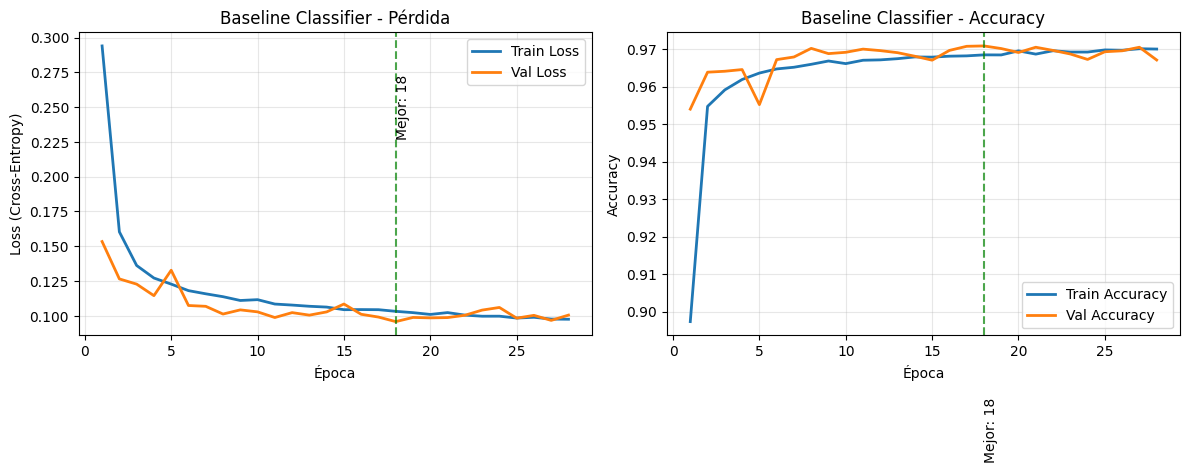

   - Accuracy en validación: 0.9671
   - Performance Gap (train - val accuracy): 0.0004
Overfitting bajo - Modelo generaliza bien

Métricas del Baseline Classifier:
  Train Loss: 0.1008
  Train Accuracy: 0.9675
  Train Precision (weighted): 0.9674
  Train Recall (weighted): 0.9675
  Train F1-score (weighted): 0.9674
  Val Loss: 0.1006
  Val Accuracy: 0.9671
  Val Precision (weighted): 0.9670
  Val Recall (weighted): 0.9671
  Val F1-score (weighted): 0.9670

 COMPARACIÓN DE EXPERIMENTOS DE CLASIFICACIÓN


,name,train_accuracy,val_accuracy,val_precision,val_recall,val_f1,performance_gap
0,Baseline,NaN,NaN,NaN,NaN,NaN,NaN
1,L2_1e-05,NaN,NaN,NaN,NaN,NaN,NaN
2,L2_0.0001,NaN,NaN,NaN,NaN,NaN,NaN
3,L2_0.001,NaN,NaN,NaN,NaN,NaN,NaN
4,L2_0.01,NaN,NaN,NaN,NaN,NaN,NaN
5,Dropout_0.1,NaN,NaN,NaN,NaN,NaN,NaN
6,Dropout_0.2,NaN,NaN,NaN,NaN,NaN,NaN
7,Dropout_0.3,NaN,NaN,NaN,NaN,NaN,NaN
8,Dropout_0.5,NaN,NaN,NaN,NaN,NaN,NaN
9,Init_default,NaN,NaN,NaN,NaN,NaN,NaN



 Mejor modelo (basado en Val Accuracy): Baseline_Classifier (Val Accuracy = 0.9671)

✓ Subtarea completada: Funciones de entrenamiento/evaluación y baseline adaptados para clasificación.


In [ ]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

# === FUNCIÓN DE ENTRENAMIENTO PARA CLASIFICACIÓN ===
# Adapta la función de entrenamiento para clasificación multi-clase
def fit_classifier(model, train_ds, val_ds=None, *, epochs=100, batch_size=64, lr=1e-3,
                   patience=10, min_delta=1e-4, ckpt_path=None, compile_model=True, weight_decay=0.0):

    model.to(DEVICE)

    if compile_model and hasattr(torch, 'compile'):
        try:
            model = torch.compile(model)
            print("Modelo compilado con torch.compile para mejor rendimiento")
        except Exception as e:
            print(f' torch.compile no disponible: {e}')

    # Configuración para clasificación multi-clase
    # Usamos CrossEntropyLoss que combina LogSoftmax y NLLLoss
    criterion = nn.CrossEntropyLoss()

    opt = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)

    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)

    best = math.inf # Para early stopping basado en validation loss
    best_epoch = None
    best_state = None

    history = {
        'epoch': [],
        'loss': [],
        'accuracy': [], # Usamos accuracy como métrica principal
        'val_loss': [],
        'val_accuracy': []
    }

    for epoch in range(1, epochs + 1):
        # --- FASE DE ENTRENAMIENTO ---
        model.train()
        epoch_loss = 0.0
        n = 0
        all_train_preds = []
        all_train_y = []

        for xb, yb in train_loader:
            xb = xb.to(DEVICE)
            yb = yb.to(DEVICE)

            # Forward pass: obtener logits
            preds = model(xb)

            # Calcular pérdida (Cross-Entropy)
            # yb debe ser de tipo LongTensor
            loss = criterion(preds, yb.long())

            # Para calcular métricas, obtenemos la clase predicha
            _, predicted_classes = torch.max(preds.detach().cpu(), 1)
            all_train_preds.append(predicted_classes.numpy())
            all_train_y.append(yb.cpu().numpy())

            opt.zero_grad(set_to_none=True)
            loss.backward()
            opt.step()

            epoch_loss += loss.item() * xb.size(0)
            n += xb.size(0)

        # Calcular métricas de entrenamiento
        tr_loss = epoch_loss / n
        # Concatenar predicciones y etiquetas reales para calcular métricas globales
        train_y_true = np.concatenate(all_train_y)
        train_y_pred = np.concatenate(all_train_preds)
        tr_accuracy = accuracy_score(train_y_true, train_y_pred)


        # --- FASE DE VALIDACIÓN ---
        if val_ds is not None:
            model.eval()
            xb, yb = val_ds[:]
            xb = xb.to(DEVICE)
            yb = yb.to(DEVICE)

            with torch.no_grad():
                preds = model(xb)
                val_loss = criterion(preds, yb.long()).item() # yb debe ser LongTensor

                # Para calcular métricas de validación
                _, predicted_classes = torch.max(preds.cpu(), 1)
                val_accuracy = accuracy_score(yb.cpu().numpy(), predicted_classes.numpy())

            # Early stopping: guardar mejor modelo basado en validation loss
            if val_loss + min_delta < best:
                best = val_loss
                best_epoch = epoch
                best_state = {k: v.cpu() for k, v in model.state_dict().items()}
                if ckpt_path:
                    torch.save(best_state, ckpt_path)


        # Guardar métricas en historial
        history['epoch'].append(epoch)
        history['loss'].append(tr_loss)
        history['accuracy'].append(tr_accuracy)
        if val_ds is not None:
            history['val_loss'].append(val_loss)
            history['val_accuracy'].append(val_accuracy)


        # Imprimir progreso cada 5 épocas
        if epoch % 5 == 0:
            msg = f"[{epoch:03d}] loss={tr_loss:.4f} accuracy={tr_accuracy:.4f}"
            if val_ds is not None:
                msg += f" | val_loss={val_loss:.4f} val_accuracy={val_accuracy:.4f}"
            print(msg)

        # Early stopping: detener si no hay mejora
        if val_ds is not None and (epoch - (best_epoch or 0)) >= patience:
            print(f" Early stopping en época {epoch} (mejor época: {best_epoch})")
            break

    # Cargar pesos del mejor modelo
    if best_state is not None:
        model.load_state_dict(best_state)
        print(f" Modelo restaurado a época {best_epoch} (mejor val_loss: {best:.4f})")

    return model, history, best_epoch


# === FUNCIÓN DE EVALUACIÓN PARA CLASIFICACIÓN ===
# Evalúa un modelo de clasificación en un dataset con métricas de clasificación
@torch.no_grad()
def evaluate_classification(model, dataset, batch_size=256):
    model.eval()
    loader = DataLoader(dataset, batch_size=batch_size)

    all_y_true = []
    all_y_pred = []
    losses = []
    crit = nn.CrossEntropyLoss()

    for xb, yb in loader:
        xb = xb.to(DEVICE)
        yb = yb.to(DEVICE)

        # Predicciones (logits)
        preds = model(xb)
        loss = crit(preds, yb.long())

        # Obtener la clase predicha
        _, predicted_classes = torch.max(preds.cpu(), 1)

        all_y_true.append(yb.cpu().numpy())
        all_y_pred.append(predicted_classes.numpy())
        losses.append(loss.item())

    # Concatenar todos los resultados
    y_true = np.concatenate(all_y_true)
    y_pred = np.concatenate(all_y_pred)

    # Calcular métricas de clasificación
    accuracy = accuracy_score(y_true, y_pred)
    # Calcular Precision, Recall y F1-score. Usamos 'weighted' average due to class imbalance
    precision = precision_score(y_true, y_pred, average='weighted', zero_division=0)
    recall = recall_score(y_true, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)


    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'loss': float(np.mean(losses)),
        'y_true': y_true,
        'y_pred': y_pred
    }

# === ACTUALIZAR INFRAESTRUCTURA EXPERIMENTAL PARA CLASIFICACIÓN ===
# Modificar la función register_experiment para registrar métricas de clasificación
def register_experiment_classifier(name, description, model, history, train_metrics, val_metrics):
    results_registry['experiments'].append({
        'name': name,
        'description': description,
        'model': model,
        'history': history
    })

    results_registry['metrics'].append({
        'name': name,
        'train_accuracy': train_metrics['accuracy'],
        'train_precision': train_metrics['precision'],
        'train_recall': train_metrics['recall'],
        'train_f1': train_metrics['f1_score'],
        'val_accuracy': val_metrics['accuracy'],
        'val_precision': val_metrics['precision'],
        'val_recall': val_metrics['recall'],
        'val_f1': val_metrics['f1_score'],
        # Para clasificación, podemos usar la diferencia de accuracy como un indicador simple de overfitting/underfitting
        'performance_gap': train_metrics['accuracy'] - val_metrics['accuracy']
    })

# Modificar la función compare_experiments para comparar métricas de clasificación
def compare_experiments_classifier():
    import pandas as pd

    df_metrics = pd.DataFrame(results_registry['metrics'])

    print("\n" + "="*100)
    print(" COMPARACIÓN DE EXPERIMENTOS DE CLASIFICACIÓN")
    print("="*100)
    # Mostrar solo métricas relevantes para clasificación
    display(df_metrics[['name', 'train_accuracy', 'val_accuracy', 'val_precision', 'val_recall', 'val_f1', 'performance_gap']])
    print("="*100)

    # Identificar mejor modelo basado en validation accuracy (o F1-score si se prefiere)
    # Para clasificación, mayor accuracy es mejor
    best_idx = df_metrics['val_accuracy'].idxmax()
    best_name = df_metrics.loc[best_idx, 'name']
    best_accuracy = df_metrics.loc[best_idx, 'val_accuracy']

    print(f"\n Mejor modelo (basado en Val Accuracy): {best_name} (Val Accuracy = {best_accuracy:.4f})")

    return df_metrics


# === ENTRENAR Y EVALUAR MODELO BASELINE PARA CLASIFICACIÓN ===

print("\n" + "="*80)
print("ENTRENANDO MODELO BASELINE PARA CLASIFICACIÓN")
print("="*80)

# Configuración del baseline clasificador
# Usamos la clase FFNN_Classifier definida anteriormente
baseline_classifier_model = FFNN_Classifier(
    d0=d_in_classifier,
    d1=d_hidden1_classifier,
    d2=d_hidden2_classifier,
    n_classes=n_classes,
    dropout=0.0 # Sin dropout para el baseline
)

print(f"\n📐 Arquitectura: {d_in_classifier} → {d_hidden1_classifier} → {d_hidden2_classifier} → {n_classes}")
print(f"🔢 Parámetros: {sum(p.numel() for p in baseline_classifier_model.parameters()):,}")

# Entrenar modelo baseline clasificador
# Usamos la nueva función fit_classifier
baseline_classifier_model, baseline_classifier_history, baseline_classifier_best_epoch = fit_classifier(
    model=baseline_classifier_model,
    train_ds=train_dataset,
    val_ds=val_dataset,
    epochs=100, # Reducimos las épocas para un baseline inicial
    batch_size=64,
    lr=1e-3,
    patience=10,
    weight_decay=0.0,  # SIN regularización L2
    compile_model=False # Desactivar compile inicialmente si da problemas
)

# Evaluar en train y validation
# Usamos la nueva función evaluate_classification
baseline_classifier_train_metrics = evaluate_classification(baseline_classifier_model, train_dataset)
baseline_classifier_val_metrics = evaluate_classification(baseline_classifier_model, val_dataset)

# Registrar experimento
# Usamos la nueva función register_experiment_classifier
register_experiment_classifier(
    name="Baseline_Classifier",
    description="Clasificador sin mejoras (dropout=0, L2=0)",
    model=baseline_classifier_model,
    history=baseline_classifier_history,
    train_metrics=baseline_classifier_train_metrics,
    val_metrics=baseline_classifier_val_metrics
)

# Visualizar curvas de aprendizaje para clasificación
# Adaptar la función de plotting si es necesario, o usar métricas adecuadas
# Por ahora, podemos plotear loss y accuracy
def plot_classifier_history(h, best_epoch=None, title='Historial de Entrenamiento Clasificador'):
    x = h['epoch']
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, h['loss'], label='Train Loss', linewidth=2)
    if h.get('val_loss') and len(h['val_loss']) == len(x):
        plt.plot(x, h['val_loss'], label='Val Loss', linewidth=2)
    if best_epoch:
        plt.axvline(best_epoch, linestyle='--', color='green', alpha=0.7)
        plt.text(best_epoch, plt.ylim()[1]*0.9, f"Mejor: {best_epoch}",
                rotation=90, va='top', fontsize=10)
    plt.xlabel('Época')
    plt.ylabel('Loss (Cross-Entropy)')
    plt.title(f'{title} - Pérdida')
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.subplot(1, 2, 2)
    plt.plot(x, h['accuracy'], label='Train Accuracy', linewidth=2)
    if h.get('val_accuracy') and len(h['val_accuracy']) == len(x):
        plt.plot(x, h['val_accuracy'], label='Val Accuracy', linewidth=2)
    if best_epoch:
        plt.axvline(best_epoch, linestyle='--', color='green', alpha=0.7)
        plt.text(best_epoch, plt.ylim()[1]*0.9, f"Mejor: {best_epoch}",
                rotation=90, va='top', fontsize=10)
    plt.xlabel('Época')
    plt.ylabel('Accuracy')
    plt.title(f'{title} - Accuracy')
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

plot_classifier_history(baseline_classifier_history, best_epoch=baseline_classifier_best_epoch, title='Baseline Classifier')


# Análisis de overfitting para clasificación
performance_gap = baseline_classifier_train_metrics['accuracy'] - baseline_classifier_val_metrics['accuracy']

print(f"   - Accuracy en validación: {baseline_classifier_val_metrics['accuracy']:.4f}")
print(f"   - Performance Gap (train - val accuracy): {performance_gap:.4f}")

if performance_gap > 0.1: # Umbral de overfitting para accuracy
    print("OVERFITTING SIGNIFICATIVO - Necesitamos regularización")
elif performance_gap > 0.05:
    print("OVERFITTING MODERADO - Regularización podría ayudar")
else:
    print("Overfitting bajo - Modelo generaliza bien")

# Mostrar métricas completas del baseline
print("\nMétricas del Baseline Classifier:")
print(f"  Train Loss: {baseline_classifier_train_metrics['loss']:.4f}")
print(f"  Train Accuracy: {baseline_classifier_train_metrics['accuracy']:.4f}")
print(f"  Train Precision (weighted): {baseline_classifier_train_metrics['precision']:.4f}")
print(f"  Train Recall (weighted): {baseline_classifier_train_metrics['recall']:.4f}")
print(f"  Train F1-score (weighted): {baseline_classifier_train_metrics['f1_score']:.4f}")

print(f"  Val Loss: {baseline_classifier_val_metrics['loss']:.4f}")
print(f"  Val Accuracy: {baseline_classifier_val_metrics['accuracy']:.4f}")
print(f"  Val Precision (weighted): {baseline_classifier_val_metrics['precision']:.4f}")
print(f"  Val Recall (weighted): {baseline_classifier_val_metrics['recall']:.4f}")
print(f"  Val F1-score (weighted): {baseline_classifier_val_metrics['f1_score']:.4f}")

# Comparar experimentos (ahora con métricas de clasificación)
compare_experiments_classifier()

print("\n✓ Subtarea completada: Funciones de entrenamiento/evaluación y baseline adaptados para clasificación.")

---

# EXPERIMENTO 1: Penalización L2 (Weight Decay)

Reducir el overfitting mediante **penalización L2**, que añade un término al loss que penaliza pesos grandes.
Solo se modifica el fit


EXPERIMENTO 1: REGULARIZACIÓN L2 PARA CLASIFICACIÓN

Entrenando clasificador con Weight Decay = 1e-05
----------------------------------------
[005] loss=0.1225 accuracy=0.9635 | val_loss=0.1174 val_accuracy=0.9630
[010] loss=0.1102 accuracy=0.9667 | val_loss=0.1116 val_accuracy=0.9648
[015] loss=0.1072 accuracy=0.9675 | val_loss=0.0965 val_accuracy=0.9713
[020] loss=0.1010 accuracy=0.9691 | val_loss=0.1049 val_accuracy=0.9679
[025] loss=0.0987 accuracy=0.9697 | val_loss=0.0963 val_accuracy=0.9707
[030] loss=0.0967 accuracy=0.9700 | val_loss=0.0925 val_accuracy=0.9714
[035] loss=0.0953 accuracy=0.9705 | val_loss=0.0969 val_accuracy=0.9712
[040] loss=0.0926 accuracy=0.9710 | val_loss=0.0953 val_accuracy=0.9717
 Early stopping en época 43 (mejor época: 33)
 Modelo restaurado a época 33 (mejor val_loss: 0.0914)

Entrenando clasificador con Weight Decay = 0.0001
----------------------------------------
[005] loss=0.1225 accuracy=0.9634 | val_loss=0.1172 val_accuracy=0.9633
[010] loss=0.11

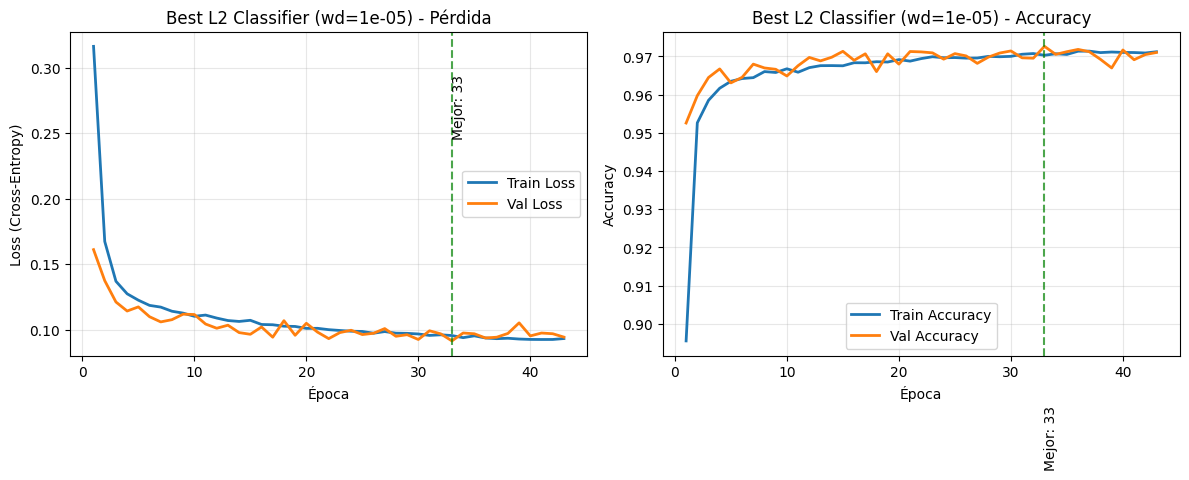


ANÁLISIS Y DECISIÓN PARA REGULARIZACIÓN L2
   INCLUIR L2 en modelo final
   → Mejora significativa en Val Accuracy: 0.0039
   → Mejor weight_decay: 1e-05

✓ Experimento 1 (L2 para Clasificación) completado


In [ ]:
# === EXPERIMENTO 1 ADAPTADO: REGULARIZACIÓN L2 PARA CLASIFICACIÓN ===

print("\n" + "="*80)
print("EXPERIMENTO 1: REGULARIZACIÓN L2 PARA CLASIFICACIÓN")
print("="*80)

# Valores de weight_decay a probar
weight_decay_values_clf = [1e-5, 1e-4, 1e-3, 1e-2]

# Almacenar resultados de este experimento
l2_classifier_results = []

# Probar cada valor de peso
for wd_clf in weight_decay_values_clf:
    print(f"\nEntrenando clasificador con Weight Decay = {wd_clf}")
    print("-"*40)

    # Fijar semilla para reproducibilidad
    set_seed(42)

    # Crear modelo (misma arquitectura que baseline clasificador)
    model_l2_clf = FFNN_Classifier(
        d0=d_in_classifier,
        d1=d_hidden1_classifier,
        d2=d_hidden2_classifier,
        n_classes=n_classes,
        dropout=0.0 # Sin dropout en este experimento
    )

    # Entrenar con regularización L2 usando fit_classifier
    model_l2_clf, history_l2_clf, best_epoch_l2_clf = fit_classifier(
        model=model_l2_clf,
        train_ds=train_dataset,
        val_ds=val_dataset,
        epochs=100, # Usar el mismo número de épocas que el baseline
        batch_size=64,
        lr=1e-3,
        patience=10,
        weight_decay=wd_clf,  # REGULARIZACIÓN L2, varia en cada ciclo
        compile_model=False # Desactivar compile si dio problemas antes
    )

    # Evaluar usando evaluate_classification
    train_metrics_l2_clf = evaluate_classification(model_l2_clf, train_dataset)
    val_metrics_l2_clf = evaluate_classification(model_l2_clf, val_dataset)

    # Guardar resultados
    l2_classifier_results.append({
        'weight_decay': wd_clf,
        'model': model_l2_clf,
        'history': history_l2_clf,
        'best_epoch': best_epoch_l2_clf,
        'train_metrics': train_metrics_l2_clf,
        'val_metrics': val_metrics_l2_clf
    })

    # Registrar experimento usando register_experiment_classifier
    register_experiment_classifier(
        name=f"L2_Classifier_{wd_clf}",
        description=f"Clasificador con Weight decay = {wd_clf}",
        model=model_l2_clf,
        history=history_l2_clf,
        train_metrics=train_metrics_l2_clf,
        val_metrics=val_metrics_l2_clf
    )

# ===  COMPARACIÓN Y SELECCIÓN DEL MEJOR WEIGHT_DECAY PARA CLASIFICACIÓN ===

print("\n" + "="*80)
print("COMPARACIÓN DE RESULTADOS L2 PARA CLASIFICACIÓN")
print("="*80)

# Imprimir resumen de resultados L2
print(f"{'Weight Decay':<15} {'Train Acc':>12} {'Val Acc':>12} {'Val F1':>12} {'Perf Gap':>12}")
print("-"*70)
for res in l2_classifier_results:
    wd_clf = res['weight_decay']
    train_acc = res['train_metrics']['accuracy']
    val_acc = res['val_metrics']['accuracy']
    val_f1 = res['val_metrics']['f1_score']
    performance_gap = res['train_metrics']['accuracy'] - res['val_metrics']['accuracy']

    print(f"{wd_clf:<15.0e} {train_acc:>12.4f} {val_acc:>12.4f} {val_f1:>12.4f} {performance_gap:>12.4f}")

print("-"*70)

# Encontrar mejor weight_decay basado en Val Accuracy
best_l2_classifier_result = max(l2_classifier_results, key=lambda x: x['val_metrics']['accuracy'])
best_wd_classifier = best_l2_classifier_result['weight_decay']
best_val_accuracy_l2_clf = best_l2_classifier_result['val_metrics']['accuracy']

print(f"\n🏆 Mejor weight_decay para clasificación: {best_wd_classifier}")
print(f"   Val Accuracy: {best_val_accuracy_l2_clf:.4f}")

# Comparación con el baseline clasificador
baseline_val_accuracy = baseline_classifier_val_metrics['accuracy']
improvement_l2_clf = best_val_accuracy_l2_clf - baseline_val_accuracy
improvement_pct_l2_clf = (improvement_l2_clf / baseline_val_accuracy) * 100

print(f"   Mejora vs Baseline: {improvement_l2_clf:.4f} ( {improvement_pct_l2_clf:.2f}%)")

# Visualizar curvas de aprendizaje del mejor modelo L2
plot_classifier_history(best_l2_classifier_result['history'], best_epoch=best_l2_classifier_result['best_epoch'], title=f'Best L2 Classifier (wd={best_wd_classifier})')


# === ANÁLISIS Y DECISIÓN PARA L2 ===
print("\n" + "="*80)
print("ANÁLISIS Y DECISIÓN PARA REGULARIZACIÓN L2")
print("="*80)

if improvement_l2_clf > 0.001: # Umbral de mejora para considerar L2
    print(f"   INCLUIR L2 en modelo final")
    print(f"   → Mejora significativa en Val Accuracy: {improvement_l2_clf:.4f}")
    print(f"   → Mejor weight_decay: {best_wd_classifier}")
    selected_wd = best_wd_classifier
    use_l2 = True
elif improvement_l2_clf > 0:
     print(f"    CONSIDERAR L2")
     print(f"   → Mejora marginal: {improvement_l2_clf:.4f}")
     print(f"   → Podría incluirse si reduce el overfitting sin penalizar accuracy")
     # Verificar si reduce overfitting (perf gap)
     best_l2_perf_gap = best_l2_classifier_result['train_metrics']['accuracy'] - best_l2_classifier_result['val_metrics']['accuracy']
     baseline_perf_gap = baseline_classifier_train_metrics['accuracy'] - baseline_classifier_val_metrics['accuracy']
     if best_l2_perf_gap < baseline_perf_gap * 0.9: # Si reduce el gap en más del 10%
         print("   → Además, ayuda a reducir el overfitting.")
         selected_wd = best_wd_classifier
         use_l2 = True
     else:
        print("   → No reduce significativamente el overfitting.")
        selected_wd = 0.0
        use_l2 = False
else:
    print(f"   NO INCLUIR L2")
    print(f"   → No hay mejora o empeora el rendimiento: {improvement_l2_clf:.4f}")
    selected_wd = 0.0
    use_l2 = False

print("\n✓ Experimento 1 (L2 para Clasificación) completado")
print("="*80)


---

# EXPERIMENTO 2: Dropout
apaga aleatoriamente un porcentaje de neuronas durante el entrenamiento:
- Durante training: Cada neurona tiene probabilidad `p` de ser desactivada
- Durante testing: Todas las neuronas están activas (se escalan por `1-p`)


EXPERIMENTO 2: DROPOUT PARA CLASIFICACIÓN

Entrenando clasificador con Dropout = 0.1
----------------------------------------
[005] loss=0.1324 accuracy=0.9591 | val_loss=0.1099 val_accuracy=0.9664
[010] loss=0.1143 accuracy=0.9656 | val_loss=0.1070 val_accuracy=0.9667
[015] loss=0.1085 accuracy=0.9675 | val_loss=0.1012 val_accuracy=0.9676
[020] loss=0.1061 accuracy=0.9685 | val_loss=0.0932 val_accuracy=0.9714
[025] loss=0.1028 accuracy=0.9691 | val_loss=0.0910 val_accuracy=0.9721
[030] loss=0.1006 accuracy=0.9694 | val_loss=0.0893 val_accuracy=0.9727
[035] loss=0.0990 accuracy=0.9706 | val_loss=0.0906 val_accuracy=0.9728
[040] loss=0.0980 accuracy=0.9697 | val_loss=0.0912 val_accuracy=0.9725
 Early stopping en época 44 (mejor época: 34)
 Modelo restaurado a época 34 (mejor val_loss: 0.0879)

Entrenando clasificador con Dropout = 0.2
----------------------------------------
[005] loss=0.1424 accuracy=0.9589 | val_loss=0.1088 val_accuracy=0.9661
[010] loss=0.1181 accuracy=0.9643 | val_

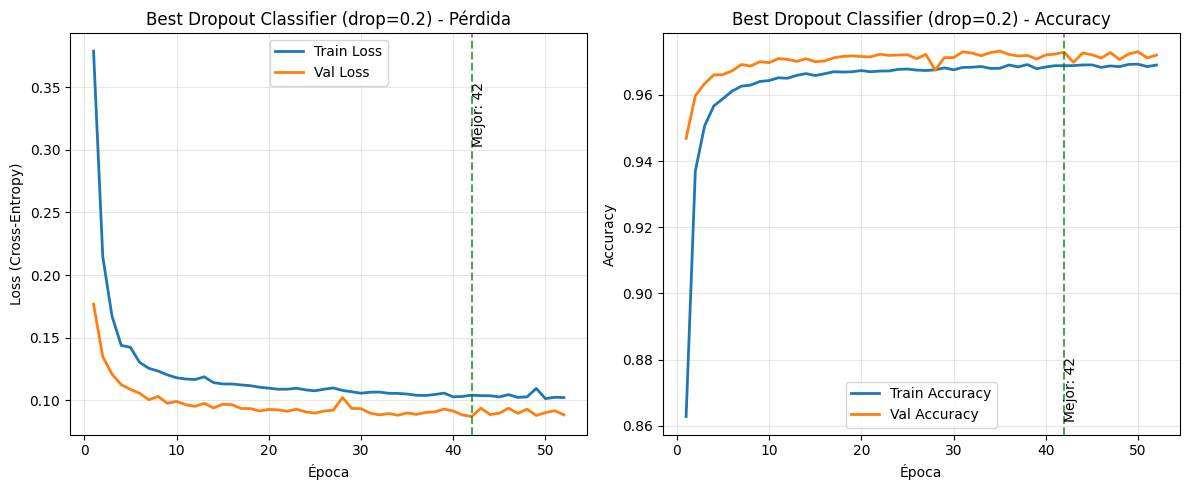


ANÁLISIS Y DECISIÓN PARA DROPOUT
   INCLUIR Dropout en modelo final
   → Mejora significativa en Val Accuracy: 0.0010
   → Mejor dropout rate: 0.2

✓ Experimento 2 (Dropout para Clasificación) completado


In [ ]:
# === EXPERIMENTO 2 ADAPTADO: DROPOUT PARA CLASIFICACIÓN ===

print("\n" + "="*80)
print("EXPERIMENTO 2: DROPOUT PARA CLASIFICACIÓN")
print("="*80)

# Valores de dropout a probar
dropout_values_clf = [0.1, 0.2, 0.3, 0.5]
dropout_classifier_results = []

# Probar cada valor de dropout
for drop_rate_clf in dropout_values_clf:
    print(f"\nEntrenando clasificador con Dropout = {drop_rate_clf}")
    print("-"*40)

    set_seed(42)

    # Crear modelo CON dropout para clasificación
    model_drop_clf = FFNN_Classifier(
        d0=d_in_classifier,
        d1=d_hidden1_classifier,
        d2=d_hidden2_classifier,
        n_classes=n_classes,
        dropout=drop_rate_clf # Aplicar dropout
    )

    # Entrenar (con el weight_decay seleccionado en experimento anterior si se decidió usarlo)
    model_drop_clf, history_drop_clf, best_epoch_drop_clf = fit_classifier(
        model=model_drop_clf,
        train_ds=train_dataset,
        val_ds=val_dataset,
        epochs=100,
        batch_size=64,
        lr=1e-3,
        patience=10,
        weight_decay=selected_wd if use_l2 else 0.0, # Usar WD seleccionado
        compile_model=False
    )

    # Evaluar
    train_metrics_drop_clf = evaluate_classification(model_drop_clf, train_dataset)
    val_metrics_drop_clf = evaluate_classification(model_drop_clf, val_dataset)

    dropout_classifier_results.append({
        'dropout': drop_rate_clf,
        'model': model_drop_clf,
        'history': history_drop_clf,
        'best_epoch': best_epoch_drop_clf, # Ensure best_epoch is stored
        'train_metrics': train_metrics_drop_clf,
        'val_metrics': val_metrics_drop_clf
    })

    register_experiment_classifier(
        name=f"Dropout_Classifier_{drop_rate_clf}",
        description=f"Clasificador con Dropout={drop_rate_clf}, WD={selected_wd if use_l2 else 0.0}",
        model=model_drop_clf,
        history=history_drop_clf,
        train_metrics=train_metrics_drop_clf,
        val_metrics=val_metrics_drop_clf
    )

# === COMPARACIÓN Y SELECCIÓN DEL MEJOR DROPOUT PARA CLASIFICACIÓN ===

print("\n" + "="*80)
print("COMPARACIÓN DE RESULTADOS DROPOUT PARA CLASIFICACIÓN")
print("="*80)

# Imprimir resumen de resultados Dropout
print(f"{'Dropout':<15} {'Train Acc':>12} {'Val Acc':>12} {'Val F1':>12} {'Perf Gap':>12}")
print("-"*70)
for res in dropout_classifier_results:
    drop_rate_clf = res['dropout']
    train_acc = res['train_metrics']['accuracy']
    val_acc = res['val_metrics']['accuracy']
    val_f1 = res['val_metrics']['f1_score']
    performance_gap = res['train_metrics']['accuracy'] - res['val_metrics']['accuracy']

    print(f"{drop_rate_clf:<15.1f} {train_acc:>12.4f} {val_acc:>12.4f} {val_f1:>12.4f} {performance_gap:>12.4f}")

print("-"*70)

# Encontrar mejor dropout basado en Val Accuracy
best_drop_classifier_result = max(dropout_classifier_results, key=lambda x: x['val_metrics']['accuracy'])
best_dropout_rate_classifier = best_drop_classifier_result['dropout']
best_val_accuracy_drop_clf = best_drop_classifier_result['val_metrics']['accuracy']

print(f"\n🏆 Mejor dropout para clasificación: {best_dropout_rate_classifier}")
print(f"   Val Accuracy: {best_val_accuracy_drop_clf:.4f}")

# Comparación con el mejor modelo anterior (L2 si se usó, sino Baseline)
baseline_ref_clf = best_l2_classifier_result if use_l2 else {'val_metrics': baseline_classifier_val_metrics}
baseline_acc_ref_clf = baseline_ref_clf['val_metrics']['accuracy']

improvement_drop_clf = best_val_accuracy_drop_clf - baseline_acc_ref_clf

print(f"   Mejora vs anterior: {improvement_drop_clf:.4f}")

# Visualizar curvas de aprendizaje del mejor modelo Dropout
# Access best_epoch from the result dictionary
plot_classifier_history(best_drop_classifier_result['history'], best_epoch=best_drop_classifier_result['best_epoch'], title=f'Best Dropout Classifier (drop={best_dropout_rate_classifier})')

# === ANÁLISIS Y DECISIÓN PARA DROPOUT ===
print("\n" + "="*80)
print("ANÁLISIS Y DECISIÓN PARA DROPOUT")
print("="*80)

if improvement_drop_clf > 0.001: # Umbral de mejora para considerar Dropout
    print(f"   INCLUIR Dropout en modelo final")
    print(f"   → Mejora significativa en Val Accuracy: {improvement_drop_clf:.4f}")
    print(f"   → Mejor dropout rate: {best_dropout_rate_classifier}")
    selected_dropout = best_dropout_rate_classifier
    use_dropout = True
elif improvement_drop_clf > 0:
     print(f"    CONSIDERAR Dropout")
     print(f"   → Mejora marginal: {improvement_drop_clf:.4f}")
     print(f"   → Podría incluirse si reduce el overfitting sin penalizar accuracy")
     # Verificar si reduce overfitting (perf gap)
     best_drop_perf_gap = best_drop_classifier_result['train_metrics']['accuracy'] - best_drop_classifier_result['val_metrics']['accuracy']

     # Retrieve the performance gap of the reference model from the results_registry
     ref_name = baseline_ref_clf['name'] if use_l2 else "Baseline_Classifier"
     ref_metrics = next(item for item in results_registry['metrics'] if item["name"] == ref_name)
     baseline_perf_gap = ref_metrics['performance_gap']


     if best_drop_perf_gap < baseline_perf_gap * 0.9: # Si reduce el gap en más del 10%
         print("   → Además, ayuda a reducir el overfitting.")
         selected_dropout = best_dropout_rate_classifier
         use_dropout = True
     else:
        print("   → No reduce significativamente el overfitting.")
        selected_dropout = 0.0
        use_dropout = False
else:
    print(f"   NO INCLUIR Dropout")
    print(f"   → No hay mejora o empeora el rendimiento: {improvement_drop_clf:.4f}")
    selected_dropout = 0.0
    use_dropout = False

print("\n✓ Experimento 2 (Dropout para Clasificación) completado")
print("="*80)


EXPERIMENTO 3: INICIALIZACIONES PARA CLASIFICACIÓN

Entrenando clasificador con Inicializacion: default
----------------------------------------
Usando inicializacion default de PyTorch
[005] loss=0.1424 accuracy=0.9589 | val_loss=0.1088 val_accuracy=0.9661
[010] loss=0.1181 accuracy=0.9643 | val_loss=0.0992 val_accuracy=0.9698
[015] loss=0.1131 accuracy=0.9658 | val_loss=0.0969 val_accuracy=0.9700
[020] loss=0.1098 accuracy=0.9674 | val_loss=0.0928 val_accuracy=0.9716
[025] loss=0.1077 accuracy=0.9678 | val_loss=0.0899 val_accuracy=0.9721
[030] loss=0.1058 accuracy=0.9676 | val_loss=0.0934 val_accuracy=0.9713
[035] loss=0.1051 accuracy=0.9680 | val_loss=0.0900 val_accuracy=0.9732
[040] loss=0.1028 accuracy=0.9685 | val_loss=0.0915 val_accuracy=0.9721
[045] loss=0.1028 accuracy=0.9691 | val_loss=0.0898 val_accuracy=0.9721
[050] loss=0.1014 accuracy=0.9693 | val_loss=0.0902 val_accuracy=0.9730
 Early stopping en época 52 (mejor época: 42)
 Modelo restaurado a época 42 (mejor val_loss: 

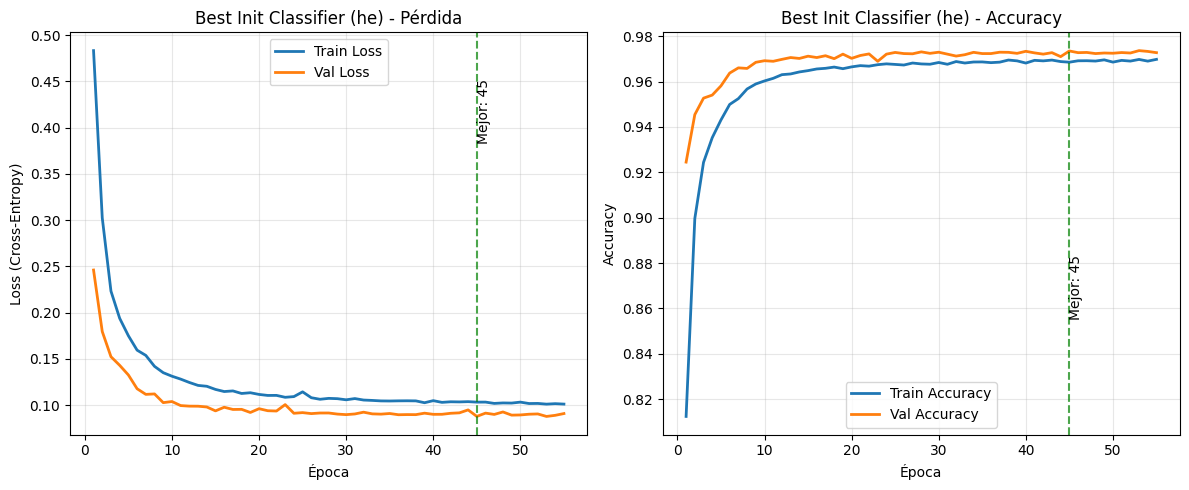


ANÁLISIS Y DECISIÓN PARA INICIALIZACIÓN
    CONSIDERAR inicialización he
   → Mejora marginal: 0.0007
   → Podría usarse si reduce el overfitting o mejora estabilidad
   → Además, ayuda a reducir el overfitting.

✓ Experimento 3 (Inicializaciones para Clasificación) completado


In [ ]:
# === EXPERIMENTO 3 ADAPTADO: INICIALIZACIONES PARA CLASIFICACIÓN ===

print("\n" + "="*80)
print("EXPERIMENTO 3: INICIALIZACIONES PARA CLASIFICACIÓN")
print("="*80)

# Funciones de inicializacion (ya definidas anteriormente)
# init_weights_xavier, init_weights_he

# Lista de inicializaciones a probar
initializations_clf = [
    ('default', None, 'Inicializacion default de PyTorch'),
    ('xavier', init_weights_xavier, 'Inicializacion Xavier (Glorot)'),
    ('he', init_weights_he, 'Inicializacion He (Kaiming) para ReLU')
]

init_classifier_results = []

# Probar cada inicializacion
for init_name_clf, init_fn_clf, init_desc_clf in initializations_clf:
    print(f"\nEntrenando clasificador con Inicializacion: {init_name_clf}")
    print("-"*40)

    set_seed(42)

    # Crear modelo clasificador (con WD y Dropout seleccionados)
    model_init_clf = FFNN_Classifier(
        d0=d_in_classifier,
        d1=d_hidden1_classifier,
        d2=d_hidden2_classifier,
        n_classes=n_classes,
        dropout=selected_dropout if use_dropout else 0.0 # Usar Dropout seleccionado
    )

    # Aplicar inicializacion
    if init_fn_clf is not None:
        model_init_clf.apply(init_fn_clf)
        print(f"Inicializacion {init_name_clf} aplicada")
    else:
        print("Usando inicializacion default de PyTorch")


    # Entrenar usando fit_classifier
    model_init_clf, history_init_clf, best_epoch_init_clf = fit_classifier(
        model=model_init_clf,
        train_ds=train_dataset,
        val_ds=val_dataset,
        epochs=100,
        batch_size=64,
        lr=1e-3,
        patience=10,
        weight_decay=selected_wd if use_l2 else 0.0, # Usar WD seleccionado
        compile_model=False
    )

    # Evaluar
    train_metrics_init_clf = evaluate_classification(model_init_clf, train_dataset)
    val_metrics_init_clf = evaluate_classification(model_init_clf, val_dataset)

    init_classifier_results.append({
        'name': init_name_clf,
        'description': init_desc_clf,
        'model': model_init_clf,
        'history': history_init_clf,
        'best_epoch': best_epoch_init_clf,
        'train_metrics': train_metrics_init_clf,
        'val_metrics': val_metrics_init_clf
    })

    register_experiment_classifier(
        name=f"Init_Classifier_{init_name_clf}",
        description=f"Clasificador con {init_desc_clf}, WD={selected_wd if use_l2 else 0.0}, Dropout={selected_dropout if use_dropout else 0.0}",
        model=model_init_clf,
        history=history_init_clf,
        train_metrics=train_metrics_init_clf,
        val_metrics=val_metrics_init_clf
    )

# === COMPARACIÓN Y SELECCIÓN DE LA MEJOR INICIALIZACIÓN PARA CLASIFICACIÓN ===

print("\n" + "="*80)
print("COMPARACIÓN DE RESULTADOS DE INICIALIZACIÓN PARA CLASIFICACIÓN")
print("="*80)

# Imprimir resumen de resultados Inicialización
print(f"{'Initialization':<25} {'Train Acc':>12} {'Val Acc':>12} {'Val F1':>12} {'Perf Gap':>12}")
print("-"*90)
for res in init_classifier_results:
    name_clf = res['name']
    train_acc = res['train_metrics']['accuracy']
    val_acc = res['val_metrics']['accuracy']
    val_f1 = res['val_metrics']['f1_score']
    performance_gap = res['train_metrics']['accuracy'] - res['val_metrics']['accuracy']
    print(f"{name_clf:<25} {train_acc:>12.4f} {val_acc:>12.4f} {val_f1:>12.4f} {performance_gap:>12.4f}")

print("-"*90)

# Mejor inicializacion basado en Val Accuracy
best_init_classifier_result = max(init_classifier_results, key=lambda x: x['val_metrics']['accuracy'])
best_init_name_classifier = best_init_classifier_result['name']
best_val_accuracy_init_clf = best_init_classifier_result['val_metrics']['accuracy']

print(f"\n🏆 Mejor inicialización para clasificación: {best_init_name_classifier}")
print(f"   Val Accuracy: {best_val_accuracy_init_clf:.4f}")

# Comparación con el mejor modelo anterior (Dropout if used, else L2 if used, else Baseline)
# Find the metrics of the best model from the previous step
if use_dropout:
    # Find the experiment with the best dropout rate
    prev_best_result = next(item for item in results_registry['metrics'] if item["name"] == f"Dropout_Classifier_{selected_dropout}")
else:
    if use_l2:
         # Find the experiment with the best L2 rate
         prev_best_result = next(item for item in results_registry['metrics'] if item["name"] == f"L2_Classifier_{selected_wd}")
    else:
         # Use baseline metrics
         prev_best_result = next(item for item in results_registry['metrics'] if item["name"] == "Baseline_Classifier")

baseline_acc_ref_clf_init = prev_best_result['val_accuracy']

improvement_init_clf = best_val_accuracy_init_clf - baseline_acc_ref_clf_init

print(f"   Mejora vs anterior: {improvement_init_clf:.4f}")

# Visualizar curvas de aprendizaje del mejor modelo Inicialización
plot_classifier_history(best_init_classifier_result['history'], best_epoch=best_init_classifier_result['best_epoch'], title=f'Best Init Classifier ({best_init_name_classifier})')

# === ANÁLISIS Y DECISIÓN PARA INICIALIZACIÓN ===
print("\n" + "="*80)
print("ANÁLISIS Y DECISIÓN PARA INICIALIZACIÓN")
print("="*80)

if improvement_init_clf > 0.001: # Umbral de mejora para considerar Inicialización
    print(f"   INCLUIR inicialización {best_init_name_classifier} en modelo final")
    print(f"   → Mejora significativa en Val Accuracy: {improvement_init_clf:.4f}")
    selected_init_name = best_init_name_classifier
    selected_init_fn = [fn for name, fn, _ in initializations_clf if name == best_init_name_classifier][0]
    use_custom_init = True
elif improvement_init_clf > 0:
    print(f"    CONSIDERAR inicialización {best_init_name_classifier}")
    print(f"   → Mejora marginal: {improvement_init_clf:.4f}")
    print(f"   → Podría usarse si reduce el overfitting o mejora estabilidad")
    # Verificar si reduce overfitting (perf gap)
    best_init_perf_gap = best_init_classifier_result['train_metrics']['accuracy'] - best_init_classifier_result['val_metrics']['accuracy']
    baseline_perf_gap_init = prev_best_result['performance_gap']

    if best_init_perf_gap < baseline_perf_gap_init * 0.9: # Si reduce el gap en más del 10%
         print("   → Además, ayuda a reducir el overfitting.")
         selected_init_name = best_init_name_classifier
         selected_init_fn = [fn for name, fn, _ in initializations_clf if name == best_init_name_classifier][0]
         use_custom_init = True
    else:
        print("   → No reduce significativamente el overfitting.")
        selected_init_name = 'default'
        selected_init_fn = None
        use_custom_init = False
else:
    print(f"   NO INCLUIR inicialización personalizada")
    print(f"   → No hay mejora o empeora el rendimiento: {improvement_init_clf:.4f}")
    selected_init_name = 'default'
    selected_init_fn = None
    use_custom_init = False

print("\n✓ Experimento 3 (Inicializaciones para Clasificación) completado")
print("="*80)


EXPERIMENTO 4: BATCH NORMALIZATION PARA CLASIFICACIÓN

Entrenando clasificador CON Batch Normalization
----------------------------------------
Inicializacion he aplicada
[005] loss=0.2000 accuracy=0.9316 | val_loss=0.1454 val_accuracy=0.9503
[010] loss=0.1675 accuracy=0.9452 | val_loss=0.1210 val_accuracy=0.9647
[015] loss=0.1544 accuracy=0.9503 | val_loss=0.1164 val_accuracy=0.9647
[020] loss=0.1464 accuracy=0.9527 | val_loss=0.1452 val_accuracy=0.9547
[025] loss=0.1435 accuracy=0.9537 | val_loss=0.1203 val_accuracy=0.9631
 Early stopping en época 29 (mejor época: 19)
 Modelo restaurado a época 19 (mejor val_loss: 0.1099)

--------------------------------------------------------------------------------
Entrenando clasificador SIN Batch Normalization (para comparacion)...
--------------------------------------------------------------------------------
Inicializacion he aplicada
[005] loss=0.1750 accuracy=0.9431 | val_loss=0.1325 val_accuracy=0.9581
[010] loss=0.1312 accuracy=0.9603 |

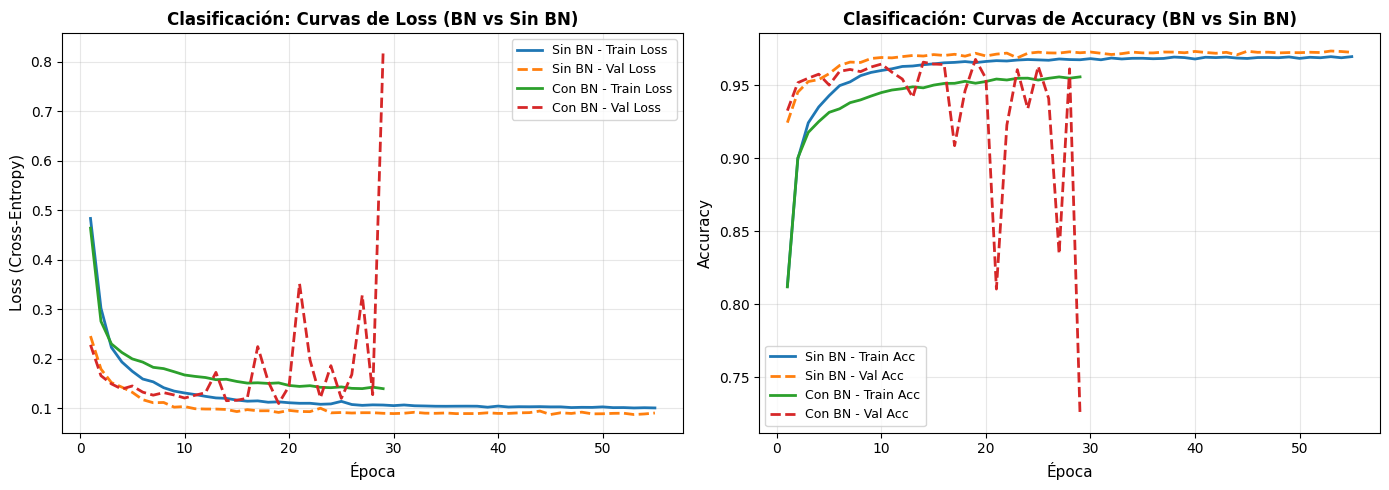


ANÁLISIS Y DECISIÓN PARA BATCH NORMALIZATION
Mejora de Batch Normalization en Val Accuracy: -0.2485

NO INCLUIR Batch Normalization
   - Mejora insuficiente: -0.2485
   - Añade complejidad sin beneficio significativo

✓ Experimento 4 (Batch Normalization para Clasificación) completado


In [ ]:
# === EXPERIMENTO 4 ADAPTADO: BATCH NORMALIZATION PARA CLASIFICACIÓN ===

print("\n" + "="*80)
print("EXPERIMENTO 4: BATCH NORMALIZATION PARA CLASIFICACIÓN")
print("="*80)

# Se crea un nuevo modelo para Batch Normalization en clasificación
class FFNN_Classifier_BN(nn.Module):

    def __init__(self, d0, d1=64, d2=64, n_classes=3, dropout=0.0):
        super().__init__()

        # Primera capa con BN y Dropout
        self.fc1 = nn.Linear(d0, d1)
        self.bn1 = nn.BatchNorm1d(d1)  # Batch Normalization
        self.dropout1 = nn.Dropout(dropout)

        # Segunda capa con BN y Dropout
        self.fc2 = nn.Linear(d1, d2)
        self.bn2 = nn.BatchNorm1d(d2)  # Batch Normalization
        self.dropout2 = nn.Dropout(dropout)

        # Capa de salida
        self.fc3 = nn.Linear(d2, n_classes) # Output layer for classification

    def forward(self, x):
        # Primera capa con BN y ReLU
        x = self.fc1(x)
        x = self.bn1(x)
        x = F.relu(x)
        # Aplicar dropout si la tasa es > 0
        if self.dropout1.p > 0:
            x = self.dropout1(x)

        # Segunda capa con BN y ReLU
        x = self.fc2(x)
        x = self.bn2(x)
        x = F.relu(x)
        # Aplicar dropout si la tasa es > 0
        if self.dropout2.p > 0:
            x = self.dropout2(x)

        # Salida (logits)
        x = self.fc3(x)
        return x


# Entrenar modelo CON Batch Normalization
print("\nEntrenando clasificador CON Batch Normalization")
print("-"*40)

set_seed(42)

model_bn_clf = FFNN_Classifier_BN(
    d0=d_in_classifier,
    d1=d_hidden1_classifier,
    d2=d_hidden2_classifier,
    n_classes=n_classes,
    dropout=selected_dropout if use_dropout else 0.0 # Usar Dropout seleccionado
)

# Aplicar inicializacion seleccionada si se decidió usarla
if use_custom_init and selected_init_fn is not None:
    model_bn_clf.apply(selected_init_fn)
    print(f"Inicializacion {selected_init_name} aplicada")

# Entrenar
model_bn_clf, history_bn_clf, best_epoch_bn_clf = fit_classifier(
    model=model_bn_clf,
    train_ds=train_dataset,
    val_ds=val_dataset,
    epochs=100,
    batch_size=64,
    lr=1e-3,
    patience=10,
    weight_decay=selected_wd if use_l2 else 0.0, # Usar WD seleccionado
    compile_model=False
)

# Evaluar
train_metrics_bn_clf = evaluate_classification(model_bn_clf, train_dataset)
val_metrics_bn_clf = evaluate_classification(model_bn_clf, val_dataset)

# Registrar experimento
register_experiment_classifier(
    name="BatchNorm_Classifier",
    description=f"Clasificador con Batch Normalization, WD={selected_wd if use_l2 else 0.0}, Dropout={selected_dropout if use_dropout else 0.0}, Init={selected_init_name if use_custom_init else 'default'}",
    model=model_bn_clf,
    history=history_bn_clf,
    train_metrics=train_metrics_bn_clf,
    val_metrics=val_metrics_bn_clf
)

# Entrenar modelo SIN Batch Normalization para comparacion
print("\n" + "-"*80)
print("Entrenando clasificador SIN Batch Normalization (para comparacion)...")
print("-"*80)

set_seed(42)

model_no_bn_clf = FFNN_Classifier(
    d0=d_in_classifier,
    d1=d_hidden1_classifier,
    d2=d_hidden2_classifier,
    n_classes=n_classes,
    dropout=selected_dropout if use_dropout else 0.0 # Usar Dropout seleccionado
)

# Aplicar inicializacion seleccionada si se decidió usarla
if use_custom_init and selected_init_fn is not None:
    model_no_bn_clf.apply(selected_init_fn)
    print(f"Inicializacion {selected_init_name} aplicada")


model_no_bn_clf, history_no_bn_clf, best_epoch_no_bn_clf = fit_classifier(
    model=model_no_bn_clf,
    train_ds=train_dataset,
    val_ds=val_dataset,
    epochs=100,
    batch_size=64,
    lr=1e-3,
    patience=10,
    weight_decay=selected_wd if use_l2 else 0.0, # Usar WD seleccionado
    compile_model=False
)

train_metrics_no_bn_clf = evaluate_classification(model_no_bn_clf, train_dataset)
val_metrics_no_bn_clf = evaluate_classification(model_no_bn_clf, val_dataset)

# === COMPARACIÓN Y DECISIÓN PARA BATCH NORMALIZATION ===
print("\n" + "="*80)
print("COMPARACIÓN DE RESULTADOS BATCH NORMALIZATION PARA CLASIFICACIÓN")
print("="*80)

print(f"{'Method':<25} {'Train Acc':>12} {'Val Acc':>12} {'Val F1':>12} {'Perf Gap':>12} {'Best Epoch':>12}")
print("-"*90)
print(f"{'Without BN':<25} {train_metrics_no_bn_clf['accuracy']:>12.4f} {val_metrics_no_bn_clf['accuracy']:>12.4f} {val_metrics_no_bn_clf['f1_score']:>12.4f} {train_metrics_no_bn_clf['accuracy'] - val_metrics_no_bn_clf['accuracy']:>12.4f} {best_epoch_no_bn_clf:>12}")
print(f"{'With BN':<25} {train_metrics_bn_clf['accuracy']:>12.4f} {val_metrics_bn_clf['accuracy']:>12.4f} {val_metrics_bn_clf['f1_score']:>12.4f} {train_metrics_bn_clf['accuracy'] - val_metrics_bn_clf['accuracy']:>12.4f} {best_epoch_bn_clf:>12}")
print("-"*90)


# Visualizacion de curvas de aprendizaje comparando BN y sin BN
plt.figure(figsize=(14, 5))

# Grafico 1: Curvas de Loss
plt.subplot(1, 2, 1)
plt.plot(history_no_bn_clf['epoch'], history_no_bn_clf['loss'], label='Sin BN - Train Loss', linewidth=2)
if history_no_bn_clf.get('val_loss') and len(history_no_bn_clf['val_loss']) == len(history_no_bn_clf['epoch']):
    plt.plot(history_no_bn_clf['epoch'], history_no_bn_clf['val_loss'], label='Sin BN - Val Loss', linewidth=2, linestyle='--')
plt.plot(history_bn_clf['epoch'], history_bn_clf['loss'], label='Con BN - Train Loss', linewidth=2)
if history_bn_clf.get('val_loss') and len(history_bn_clf['val_loss']) == len(history_bn_clf['epoch']):
    plt.plot(history_bn_clf['epoch'], history_bn_clf['val_loss'], label='Con BN - Val Loss', linewidth=2, linestyle='--')
plt.xlabel('Época', fontsize=11)
plt.ylabel('Loss (Cross-Entropy)', fontsize=11)
plt.title('Clasificación: Curvas de Loss (BN vs Sin BN)', fontsize=12, fontweight='bold')
plt.legend(fontsize=9)
plt.grid(True, alpha=0.3)

# Grafico 2: Curvas de Accuracy
plt.subplot(1, 2, 2)
plt.plot(history_no_bn_clf['epoch'], history_no_bn_clf['accuracy'], label='Sin BN - Train Acc', linewidth=2)
if history_no_bn_clf.get('val_accuracy') and len(history_no_bn_clf['val_accuracy']) == len(history_no_bn_clf['epoch']):
    plt.plot(history_no_bn_clf['epoch'], history_no_bn_clf['val_accuracy'], label='Sin BN - Val Acc', linewidth=2, linestyle='--')
plt.plot(history_bn_clf['epoch'], history_bn_clf['accuracy'], label='Con BN - Train Acc', linewidth=2)
if history_bn_clf.get('val_accuracy') and len(history_bn_clf['val_accuracy']) == len(history_bn_clf['epoch']):
    plt.plot(history_bn_clf['epoch'], history_bn_clf['val_accuracy'], label='Con BN - Val Acc', linewidth=2, linestyle='--')
plt.xlabel('Época', fontsize=11)
plt.ylabel('Accuracy', fontsize=11)
plt.title('Clasificación: Curvas de Accuracy (BN vs Sin BN)', fontsize=12, fontweight='bold')
plt.legend(fontsize=9)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


# Decision para Batch Normalization
improvement_bn_clf = val_metrics_bn_clf['accuracy'] - val_metrics_no_bn_clf['accuracy']

print("\n" + "="*80)
print("ANÁLISIS Y DECISIÓN PARA BATCH NORMALIZATION")
print("="*80)
print(f"Mejora de Batch Normalization en Val Accuracy: {improvement_bn_clf:.4f}")

if improvement_bn_clf > 0.001: # Umbral de mejora para considerar BN
    print("\nINCLUIR Batch Normalization en modelo final")
    print("Beneficios observados:")
    if best_epoch_bn_clf and best_epoch_no_bn_clf and best_epoch_bn_clf < best_epoch_no_bn_clf:
        print(f"   - Posible convergencia mas rapida ({best_epoch_bn_clf} vs {best_epoch_no_bn_clf} epocas)")
    print(f"   - Mejor generalizacion (Accuracy aumentado en {improvement_bn_clf:.4f})")
    use_batch_norm = True
    selected_model_class = FFNN_Classifier_BN
else:
    print("\nNO INCLUIR Batch Normalization")
    print(f"   - Mejora insuficiente: {improvement_bn_clf:.4f}")
    print("   - Añade complejidad sin beneficio significativo")
    use_batch_norm = False
    selected_model_class = FFNN_Classifier

print("\n✓ Experimento 4 (Batch Normalization para Clasificación) completado")
print("="*80)